<a href="https://colab.research.google.com/github/americano-diana/nn_acoustic/blob/main/finetune_wav_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project:
This notebook stands as the first version of the script written by DPAG as part of the DFG-funded Research Project "Resolving the cognitive and neural basis of affective sound-meaning associations" under supervision of Dr. Arash Aryani, PostDoc researcher at FU Berlin.

## Goal:
We aim to fine-tune existing auditory DNNs in order to model and predict arousal & valence ratings from non-words.

##Models:
Current Model being used is Wav2Vec2

Huggingface: https://huggingface.co/facebook/wav2vec2-base-960h

Paper link: https://arxiv.org/abs/2006.11477

Short description: This model is a transformer-based model that learned speech representations on unlabeled data.

Why it's fitting for the project:

+ Pre-trained on shorter speech units than phonemes, this should make it so it's better for recognizing non-words compared to other models
+ There's literature on how the model layers effectively encode acoustic and phonetic information.

##Dataset:
Data utilized was gathered by Dr. Arash Aryani - not publically available at the moment.

## Model #1. Wav2vec 2.0: A Framework for Self-Supervised Learning of Speech Representations

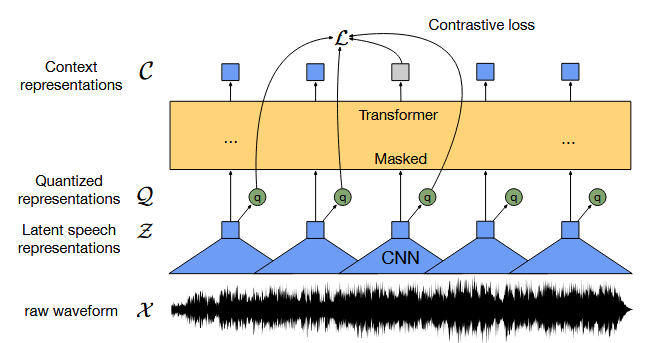

Figure 1: Illustration of Wav2vec framework which jointly learns contextualized speech representations and an inventory of discretized speech units.

[Source](https://arxiv.org/abs/2006.11477)


## Full description based off paper
Model is composed of a multi-layer convolutional feature encoders
$f : X → Z$ taking in input raw audio $X$ and outputs latent speech representations $z1, ..., zT$ for $T$ time-steps.
Then they are fed to a Transformer $g : Z → C$ to build representations $c1, ..., cT$ capturing information from the entire sequence.
Output of feature encoder is discretized to $qT$ with a quantization module $Z
→ Q$ to represent targets.

Input: Input is the raw audio waveform in the shape of $[1, T_n]$ (where T is the amplitude (with n = number of samples) of the sound wave)

Feature encoder:
Encoder consists of several blocks of temporal convolution followed by layer normalization and GELU activation function.
The raw waveform input to the encoder is normalized to zero mean and unit variance.
Output will be $Z = {z_1,z_2, ...., z_n}$ where each $z_n$ is a vector (latent feature)
It ends up being like a "learned spectogram" matrix.

Transformer modules:
Output of feature encoder is fed to a context network with Transformer architecture. Transformer layers go over the entire $Z$ sequence and give an output $C = {c_1,c_2, ...., c_n} $ - contextualized representations. This contextualized representation is what we use for doing the fine-tuning.

Quantization module (only used for pre-training, not fine-tuning):
For self-supervised training of the model, output of feature encoder z was discretized to a finite set of speech representations via product quantization. - This module is only necessary for pre-training of the model, not needed in the fine-tuning.

Pretraining:
Model was pre-trained masking a certain proportion of time steps in the latent feature encoder space. Final model was fine-tuned on labeled data. For this project's purpose, we shall take the pre-trained version of the model and fine-tune utilizing our own labeled data.

BASE (more compact) model version contains:
12 transformer blocks, model dimension 768, inner dimension (FFN) 3,072 and 8 attention heads. Batches are built by cropping 250k audio samples, or 15.6sec, from each . A LARGE version of the model exists with 24 transformer blocks and model_dim 1024.

## Importing libraries
Libraries used will be later gathered into a requirements file

In [ ]:
# Necessary to install only once if on collab, otherwise installl within local environment
# !pip install datasets transformers torchaudio librosa

In [ ]:
# Import torch libraries
import torch
import transformers
import torchaudio
import librosa
from torch import nn

# Importing other libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Library for progress bars

# Set device = GPU if available // Most important for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Loading & merging dataset

Audiofiles and metadata were stored separately so first step was cleaning and merging data so that filenames in labels.csv fit the .wav filenames.

In [ ]:
## Data only available locally for now

# Set base dir
base_dir = "/content/drive/MyDrive/Arash Projects"

# Files dir and labels dir
wav_dir = os.path.join(base_dir, "wav_files")
labels_dir = os.path.join(base_dir, "labels.csv")

# Load labels file
main_df = pd.read_csv(labels_dir)

print(main_df.head())


   filename  Klang Arousal  Klang Valence
0       107       3.083333       2.666667
1       722       3.500000       3.214286
2       881       2.454545       3.400000
3       232       3.384615       3.166667
4      1062       3.461538       3.000000


In [ ]:
# Load sample batch of audio files and corresponding metadata

# Create copy of main df
labels_df = main_df.copy()

# Convert numeric filenames in CSV to string and append '.wav'
labels_df['filename'] = labels_df['filename'].astype(str) + ".wav"

# Get only actual .wav files in the directory (ignore other files in folder)
wav_files = set(f for f in os.listdir(wav_dir) if f.lower().endswith(".wav"))

# Keep only CSV rows where the .wav file actually exists
labels_df = labels_df[labels_df['filename'].isin(wav_files)].reset_index(drop=True)

# Choose size of batch, first test batch was 100, doing 1000 now
labels_df = labels_df.head(1000)

In [ ]:
# Initialize separate lists for waveforms, valence and arousal labels
waveforms = []
valences = []
arousals = []
sample_rates = []

# Load waveforms and labels
for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Loading audio files"):
    file_path = os.path.join(wav_dir, row['filename'])

    # Load audio using torchaudio
    waveform, sample_rate = torchaudio.load(file_path)

    # Append waveform and labels
    waveforms.append(waveform)
    sample_rates.append(sample_rate)
    valences.append(row['Klang Valence'])
    arousals.append(row['Klang Arousal'])

# Print the list of used files and their labels
print("\n=== Selected Files with Klang Valence and Arousal Ratings ===")
for i in range(len(labels_df)):
    filename = labels_df.loc[i, 'filename']
    valence = valences[i]
    arousal = arousals[i]
    print(f"{i+1:03d}: {filename} --> Valence: {valence:.2f}, Arousal: {arousal:.2f}")


Loading audio files:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r


=== Selected Files with Klang Valence and Arousal Ratings ===
001: 107.wav --> Valence: 2.67, Arousal: 3.08
002: 722.wav --> Valence: 3.21, Arousal: 3.50
003: 881.wav --> Valence: 3.40, Arousal: 2.45
004: 232.wav --> Valence: 3.17, Arousal: 3.38
005: 1062.wav --> Valence: 3.00, Arousal: 3.46
006: 364.wav --> Valence: 2.46, Arousal: 3.33
007: 1016.wav --> Valence: 3.08, Arousal: 3.40
008: 77.wav --> Valence: 2.73, Arousal: 3.12
009: 612.wav --> Valence: 3.33, Arousal: 2.92
010: 590.wav --> Valence: 2.57, Arousal: 2.41
011: 657.wav --> Valence: 3.00, Arousal: 2.40
012: 617.wav --> Valence: 2.53, Arousal: 3.00
013: 535.wav --> Valence: 3.11, Arousal: 2.35
014: 103.wav --> Valence: 2.86, Arousal: 2.20
015: 1009.wav --> Valence: 2.33, Arousal: 4.00
016: 221.wav --> Valence: 2.36, Arousal: 3.14
017: 759.wav --> Valence: 2.44, Arousal: 3.55
018: 496.wav --> Valence: 2.71, Arousal: 3.08
019: 391.wav --> Valence: 2.29, Arousal: 3.00
020: 750.wav --> Valence: 2.71, Arousal: 3.24
021: 830.wav --

## Resample and prepare data

In [ ]:
# Resample files into 16HZ - specific requirement to this model

model_sr = 16000

# Initialize list for resampled waveforms
resampled_waveforms = []

# For loop for resampling all waveforms
print("\n=== Resampling Waveforms to 16kHz ===")
for i, waveform in enumerate(waveforms):
    orig_sr = sample_rates[i]

    if orig_sr != model_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=model_sr)
        waveform = resampler(waveform)

    resampled_waveforms.append(waveform)
    print(f"{i+1:03d}: Resampled to {model_sr}Hz | Shape: {waveform.shape}")


=== Resampling Waveforms to 16kHz ===
001: Resampled to 16000Hz | Shape: torch.Size([1, 15680])
002: Resampled to 16000Hz | Shape: torch.Size([1, 16640])
003: Resampled to 16000Hz | Shape: torch.Size([1, 10400])
004: Resampled to 16000Hz | Shape: torch.Size([1, 13920])
005: Resampled to 16000Hz | Shape: torch.Size([1, 12640])
006: Resampled to 16000Hz | Shape: torch.Size([1, 12800])
007: Resampled to 16000Hz | Shape: torch.Size([1, 14080])
008: Resampled to 16000Hz | Shape: torch.Size([1, 17440])
009: Resampled to 16000Hz | Shape: torch.Size([1, 12960])
010: Resampled to 16000Hz | Shape: torch.Size([1, 13440])
011: Resampled to 16000Hz | Shape: torch.Size([1, 8800])
012: Resampled to 16000Hz | Shape: torch.Size([1, 15840])
013: Resampled to 16000Hz | Shape: torch.Size([1, 19840])
014: Resampled to 16000Hz | Shape: torch.Size([1, 8640])
015: Resampled to 16000Hz | Shape: torch.Size([1, 13920])
016: Resampled to 16000Hz | Shape: torch.Size([1, 13120])
017: Resampled to 16000Hz | Shape: 

In [ ]:
# Building tensor data list for dataset class

# Combine waveforms and labels into list of (waveform, label_tensor)
data_list = []

for i in range(len(resampled_waveforms)):
    waveform = resampled_waveforms[i]
    label = torch.tensor([valences[i], arousals[i]], dtype=torch.float32)
    data_list.append((waveform, label))

# Define dataset classes

In [ ]:
class EmotionRegressionDataset(torch.utils.data.Dataset):
    """
    Creates a dataset class called "EmotionRegression Dataset" that takes in the waveforms
    and a chosen target (either valence or arousal)
    """
    def __init__(self, waveforms, targets):
        self.waveforms = waveforms
        self.targets = targets  # Single label (valence or arousal)

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        return self.waveforms[idx], torch.tensor(self.targets[idx], dtype=torch.float32)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """
    Takes in waveform batch and adds padding
    Necessary because the waveforms have different dimensions
    """
    waveforms, labels = zip(*batch)  # unzip batch of tuples

    # Remove channel dim [1, T] → [T]
    waveforms = [w.squeeze(0) for w in waveforms]  # list of [T]

    # Pad sequence [B, T]
    waveforms_padded = pad_sequence(waveforms, batch_first=True)

    # Convert labels to tensor → [B]
    labels_tensor = torch.tensor(labels).float()  # [B]

    return waveforms_padded, labels_tensor

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Creating a 3-way split data: training, validation and testing

# 70% training, 15% val + 15% test
train_indices, temp_indices = train_test_split(
    range(len(resampled_waveforms)),
    test_size=0.3,  # 30% for validation + test
    random_state=42
)

# Second split: This gives us 15% validation and 15% test
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    random_state=42
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"Test samples: {len(test_indices)}")


# Training lists
train_waveforms = [resampled_waveforms[i] for i in train_indices]
train_valences = [valences[i] for i in train_indices]
train_arousals = [arousals[i] for i in train_indices]
train_filenames = [labels_df.iloc[i]['filename'] for i in train_indices]

# Validation lists
val_waveforms = [resampled_waveforms[i] for i in val_indices]
val_valences = [valences[i] for i in val_indices]
val_arousals = [arousals[i] for i in val_indices]
val_filenames = [labels_df.iloc[i]['filename'] for i in val_indices]

# Test lists
test_waveforms = [resampled_waveforms[i] for i in test_indices]
test_valences = [valences[i] for i in test_indices]
test_arousals = [arousals[i] for i in test_indices]
test_filenames = [labels_df.iloc[i]['filename'] for i in test_indices]

# Creating datasets, 3 per model (valence and arousal)
# VALENCE datasets
valence_train_dataset = EmotionRegressionDataset(train_waveforms, train_valences)
valence_val_dataset = EmotionRegressionDataset(val_waveforms, val_valences)
valence_test_dataset = EmotionRegressionDataset(test_waveforms, test_valences)

# AROUSAL datasets
arousal_train_dataset = EmotionRegressionDataset(train_waveforms, train_arousals)
arousal_val_dataset = EmotionRegressionDataset(val_waveforms, val_arousals)
arousal_test_dataset = EmotionRegressionDataset(test_waveforms, test_arousals)

# Creating dataloaders
batch_size = 8 # can be 16 with bigger batch

# VALENCE dataloaders
valence_train_loader = DataLoader(valence_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valence_val_loader = DataLoader(valence_val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
valence_test_loader = DataLoader(valence_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# AROUSAL dataloaders
arousal_train_loader = DataLoader(arousal_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
arousal_val_loader = DataLoader(arousal_val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
arousal_test_loader = DataLoader(arousal_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print("\n Data splitting complete!")

Training samples: 700
Validation samples: 150
Test samples: 150

✅ Data splitting complete!
Now you have:
  - valence_train_loader, valence_val_loader, valence_test_loader
  - arousal_train_loader, arousal_val_loader, arousal_test_loader


## Loading model

After testing on a local script I will be using the german-fine-tuned wav2vec2 model. Testing & training first with a batch of 100 files for arousal was relatively successful. I will do two separate models for valence and arousal.


In [ ]:
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset

 # Load pretrained model and processor
model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-german"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [ ]:
# Function to preprocess audio before passing to model

def preprocess_batch(waveforms, sampling_rate=16000): #Sampling rate for this model is 16000 HZ
    # waveforms: Tensor [B, T]
    waveform_list = [waveforms[i].cpu().numpy() for i in range(waveforms.shape[0])]
    inputs = processor(waveform_list, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    return inputs.input_values, inputs.attention_mask

# Fine-tuning

In [ ]:
# Adding regression head
# Basic regressor head that adds a linear layer taking in the input of the last
# pre-built model layer and outputs to 128 nodes, ReLU function is applied
# 2nd linear layer gives 1 ouput, a scalar

class Wav2Vec2Regression (nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.wav2vec2 = base_model
        self.regressor = nn.Sequential(
            nn.Linear(self.wav2vec2.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)  # Just 1 output: valence or arousal
        )

    def forward(self, input_values, attention_mask=None):
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state.mean(dim=1)
        return self.regressor(pooled).squeeze(1)

# Training function

In [ ]:
def train_with_validation(
    model,
    train_dataloader,
    val_dataloader,
    processor,
    optimizer,
    criterion,
    device,
    num_epochs,
    sampling_rate,
    verbose=True
):
    """
    Training function that also evaluates on validation set each epoch
    """
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0

        train_loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

        for waveforms, targets in train_loop:
            waveforms = waveforms.to(device)
            targets = targets.to(device)

            input_values, attention_mask = preprocess_batch(waveforms, sampling_rate)
            input_values = input_values.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_values, attention_mask=attention_mask)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0

        val_loop = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)

        with torch.no_grad():
            for waveforms, targets in val_loop:
                waveforms = waveforms.to(device)
                targets = targets.to(device)

                input_values, attention_mask = preprocess_batch(waveforms, sampling_rate)
                input_values = input_values.to(device)
                attention_mask = attention_mask.to(device)

                outputs = model(input_values, attention_mask=attention_mask)
                loss = criterion(outputs, targets)

                running_val_loss += loss.item()
                val_loop.set_postfix(loss=loss.item())

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

# Training valence model

In [ ]:
# # Load encoder model
base_model = Wav2Vec2Model.from_pretrained(model_name)

# # Now wrap in valence regression class
valence_model = Wav2Vec2Regression(base_model=base_model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(valence_model.parameters(), lr=2e-5) #Using valence_model.parameters

# Applying training function
train_losses, val_losses = train_with_validation(
    model=valence_model,
    train_dataloader=valence_train_loader,
    val_dataloader=valence_val_loader,
    processor=processor,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=3, # 3 epochs seem to be enough
    sampling_rate= model_sr,
)

Epoch 1/3 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/3 [Val]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 2.3370, Val Loss: 0.1538


Epoch 2/3 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2/3 [Val]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.1845, Val Loss: 0.1411


Epoch 3/3 [Train]:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3/3 [Val]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.1819, Val Loss: 0.1362


## Training arousal model

In [ ]:
# # Load encoder model
# base_model = Wav2Vec2Model.from_pretrained(model_name)

# # Now wrap in valence regression class
# arousal_model = Wav2Vec2Regression(base_model=base_model)

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(arousal_model.parameters(), lr=2e-5) #Using arousal_model.parameters

# # Applying training function
# train_losses, val_losses = train_with_validation(
#     model=arousal_model,
#     train_dataloader=arousal_train_loader,
#     val_dataloader=arousal_val_loader,
#     processor=processor,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=device,
#     num_epochs=3, # 3 epochs seem to be enough
#     sampling_rate= model_sr,
# )

# Testing & Results

In [ ]:
print("Train Losses:", train_losses)
print("Val Losses:", val_losses)

Train Losses: [3.0434874560345304, 0.19930885727940637, 0.1890683138150383]
Val Losses: [0.14403261616826057, 0.13801364777119537, 0.1372074161313082]


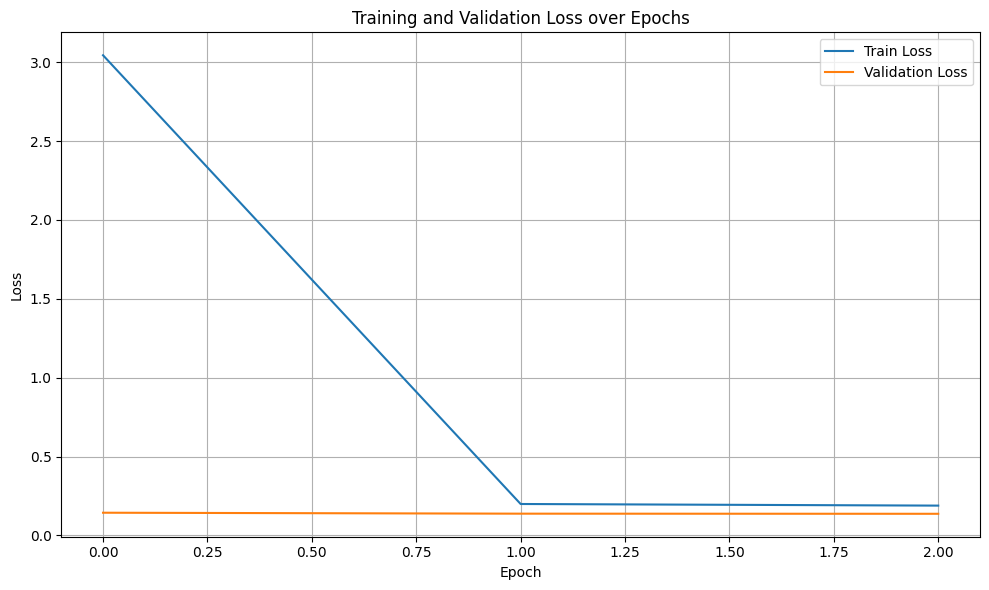

In [ ]:
def plot_losses(train_losses, val_losses):
    """
    Plot training and validation losses over epochs.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_losses(train_losses, val_losses)

In [ ]:
def test_model(
    model,
    test_dataloader,
    processor,
    criterion,
    device,
    sampling_rate,
    verbose=True):
    """
    Evaluate the model on a test set and return average test loss.
    """
    model.to(device)
    model.eval()

    running_test_loss = 0.0

    test_loop = tqdm(test_dataloader, desc="Testing", leave=False)

    with torch.no_grad():
        for waveforms, targets in test_loop:
            waveforms = waveforms.to(device)
            targets = targets.to(device)

            input_values, attention_mask = preprocess_batch(waveforms, sampling_rate)
            input_values = input_values.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_values, attention_mask=attention_mask)
            loss = criterion(outputs, targets)

            running_test_loss += loss.item()
            test_loop.set_postfix(loss=loss.item())

    avg_test_loss = running_test_loss / len(test_dataloader)

    if verbose:
        print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss

test_loss = test_model(
    model=valence_model,
    test_dataloader=valence_test_loader,
    processor=processor,
    criterion=criterion,
    device=device,
    sampling_rate= model_sr,
)

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Test Loss: 0.1996


In [ ]:
# Next: Save trained weights

model_save_path = "/content/drive/MyDrive/Arash Projects/valence_model_1st.pth"
torch.save(valence_model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to /content/drive/MyDrive/Arash Projects/valence_model_1st.pth


# Notes from 1st models

Valence model, 3 epochs
Train Losses: [2.8546715267002583, 0.252207246651365, 0.2102653395638547]
Val Losses: [0.24600882592954135, 0.14683305472135544, 0.14093608056244097]
Test Loss: 0.2096

--

Arousal model, 3 epochs

Train Losses: [3.473774565553123, 0.35841380000453105, 0.34318133210763335]
Val Losses: [0.3229877329186389, 0.305494990788008, 0.30603881297927155]

Test Loss: 0.2861

## Next steps:
Do cross-validation
2-split - train vs test
Split data into halves, train and fine-tune, normalize if needed.

Compare real vs predictions - add a plot with variance

If all looks good, then Add all stimuli to model.

Later on: We can also optimize hyperparameters such as the layer n, node n, learning rate, optimizer, dropout, etc. with [Optuna](https://optuna.org/).

## Loading and testing 1st models

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def test_stats(
    model,
    test_dataloader,
    processor,
    criterion,
    device,
    sampling_rate,
    verbose=True):
    """
    Evaluate the model on test set, return predictions and stats
    """
    model.to(device)
    model.eval()

    running_test_loss = 0.0

    all_preds = []
    all_targets = []

    test_loop = tqdm(test_dataloader, desc="Testing", leave=False)

    with torch.no_grad():
        for waveforms, targets in test_loop:
            waveforms = waveforms.to(device)
            targets = targets.to(device)

            input_values, attention_mask = preprocess_batch(waveforms, sampling_rate)
            input_values = input_values.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_values, attention_mask=attention_mask)

            # Squeezing for regression preds
            outputs = outputs.squeeze()

            loss = criterion(outputs, targets)
            running_test_loss += loss.item()

            all_preds.append(outputs.detach().cpu().numpy())
            all_targets.append(targets.detach().cpu().numpy())

            test_loop.set_postfix(loss=loss.item())

    avg_test_loss = running_test_loss / len(test_dataloader)

 # Convert to arrays
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Compute regression metrics
    r2 = r2_score(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)

    if verbose:
        print(f"Test & Stats results for model {model}")
        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"R² Score: {r2:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")

    return avg_test_loss, r2, mse, mae, all_preds, all_targets

In [ ]:
# Recreate base model and regression head wrapper
arousal_base_model = Wav2Vec2Model.from_pretrained(model_name)
arousal_model = Wav2Vec2Regression(base_model=arousal_base_model)

# Load saved weights
arousal_model__path = "/content/drive/MyDrive/Arash Projects/arousal_model_1st.pth"

# Load the saved weights
checkpoint = torch.load(arousal_model__path, map_location=device)
arousal_model.load_state_dict(checkpoint)
arousal_model.to(device)
arousal_model.eval()

Wav2Vec2Regression(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (pr

In [ ]:
# Testing aro model

aro_test_loss, aro_r2, aro_mse, aro_mae, aro_preds, aro_targets = test_stats(
    model=arousal_model,
    test_dataloader=arousal_test_loader,
    processor=processor,
    criterion=criterion,
    device=device,
    sampling_rate=model_sr,
)

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Test & Stats results for model Wav2Vec2Regression(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, ele

In [ ]:
# Recreating architecture
valence_base_model = Wav2Vec2Model.from_pretrained(model_name)
valence_model_1st = Wav2Vec2Regression(base_model=valence_base_model)

# Loading saved weights
valence_model_path = "/content/drive/MyDrive/Arash Projects/valence_model_1st.pth"
checkpoint = torch.load(valence_model_path, map_location=device)
valence_model_1st.load_state_dict(checkpoint)
valence_model_1st.to(device)
valence_model_1st.eval()

Wav2Vec2Regression(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (pr

In [ ]:
# Testing val model

val_test_loss, val_r2, val_mse, val_mae, val_preds, val_targets = test_stats(
    model=valence_model_1st,
    test_dataloader=valence_test_loader,
    processor=processor,
    criterion=criterion,
    device=device,
    sampling_rate=model_sr,
)

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Test & Stats results for model Wav2Vec2Regression(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, ele

In [ ]:
# Checking data distribution because it seems like model is prediction within a limited range (2.5-3)

from scipy import stats

def model_comparison(targets, preds, test_loss=None, r2=None, mse=None, mae=None, bins=30):
    """
    Shows model performance and
    Plots distribution comparison between targets and predictions
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Convert to numpy if tensors
    if hasattr(targets, 'cpu'):
        targets = targets.cpu().numpy()
    if hasattr(preds, 'cpu'):
        preds = preds.cpu().numpy()

    # Flatten if needed
    targets = targets.flatten()
    preds = preds.flatten()

    # 1. Overlaid histograms
    axes[0, 0].hist(targets, bins=bins, alpha=0.7, label='Targets',
                    color='blue', density=True, edgecolor='black', linewidth=0.5)
    axes[0, 0].hist(preds, bins=bins, alpha=0.7, label='Predictions',
                    color='red', density=True, edgecolor='black', linewidth=0.5)
    axes[0, 0].set_xlabel('Value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Distribution Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Add statistics text
    target_stats = f'Targets: μ={np.mean(targets):.3f}, σ={np.std(targets):.3f}'
    pred_stats = f'Preds: μ={np.mean(preds):.3f}, σ={np.std(preds):.3f}'
    axes[0, 0].text(0.02, 0.98, f'{target_stats}\n{pred_stats}',
                    transform=axes[0, 0].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # 2. Box plots side by side
    box_data = [targets, preds]
    box_labels = ['Targets', 'Predictions']
    axes[0, 1].boxplot(box_data, labels=box_labels, patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].set_title('Box Plot Comparison')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Scatter plot (actual vs predicted)
    axes[1, 0].scatter(targets, preds, alpha=0.6, s=20)

    # Add perfect prediction line
    min_val = min(np.min(targets), np.min(preds))
    max_val = max(np.max(targets), np.max(preds))
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--',
                    linewidth=2, label='Perfect prediction')

    axes[1, 0].set_xlabel('Target Values')
    axes[1, 0].set_ylabel('Predicted Values')
    axes[1, 0].set_title('Actual vs Predicted')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    if r2 is not None:
        axes[1, 0].text(0.05, 0.95, f'R² = {r2:.4f}',
                        transform=axes[1, 0].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                        fontsize=12, fontweight='bold')

    # 4. Q-Q plot
    stats.probplot(val_targets, plot=axes[1, 1], rvalue=True)
    axes[1, 1].get_lines()[0].set_markerfacecolor('blue')
    axes[1, 1].get_lines()[0].set_markeredgecolor('blue')
    axes[1, 1].get_lines()[0].set_label('Targets')

    # Add predictions to Q-Q plot
    stats.probplot(val_preds, plot=axes[1, 1], rvalue=True)
    axes[1, 1].get_lines()[2].set_markerfacecolor('red')
    axes[1, 1].get_lines()[2].set_markeredgecolor('red')
    axes[1, 1].get_lines()[2].set_label('Predictions')
    axes[1, 1].set_title('Q-Q Plot vs Normal Distribution')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # Print detailed statistics

    # Print test statistics if included
    if test_loss is not None or r2 is not None or mse is not None or mae is not None:
        print("\n" + "="*50)
        print("MODEL PERFORMANCE:")
        print("="*50)
        if test_loss is not None:
            print(f"Test Loss: {test_loss:.4f}")
        if r2 is not None:
            print(f"R² Score: {r2:.4f}")
        if mse is not None:
            print(f"MSE: {mse:.4f}")
        if mae is not None:
            print(f"MAE: {mae:.4f}")
        print("-" * 50)

    print("\n" + "="*50)
    print("DISTRIBUTION ANALYSIS")
    print("="*50)
    print(f"Targets    - Range: [{np.min(targets):.3f}, {np.max(targets):.3f}]")
    print(f"Predictions- Range: [{np.min(preds):.3f}, {np.max(preds):.3f}]")
    print(f"Target range span: {np.max(targets) - np.min(targets):.3f}")
    print(f"Prediction range span: {np.max(preds) - np.min(preds):.3f}")
    print(f"Range compression ratio: {(np.max(preds) - np.min(preds)) / (np.max(targets) - np.min(targets)):.3f}")

    print(f"\nTargets    - Mean: {np.mean(targets):.3f}, Std: {np.std(targets):.3f}")
    print(f"Predictions- Mean: {np.mean(preds):.3f}, Std: {np.std(preds):.3f}")

    # Percentile analysis
    target_percentiles = np.percentile(targets, [5, 25, 50, 75, 95])
    pred_percentiles = np.percentile(preds, [5, 25, 50, 75, 95])

    print(f"\nPercentiles (5th, 25th, 50th, 75th, 95th):")
    print(f"Targets:     {target_percentiles}")
    print(f"Predictions: {pred_percentiles}")

/tmp/ipython-input-2415096797.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(box_data, labels=box_labels, patch_artist=True,


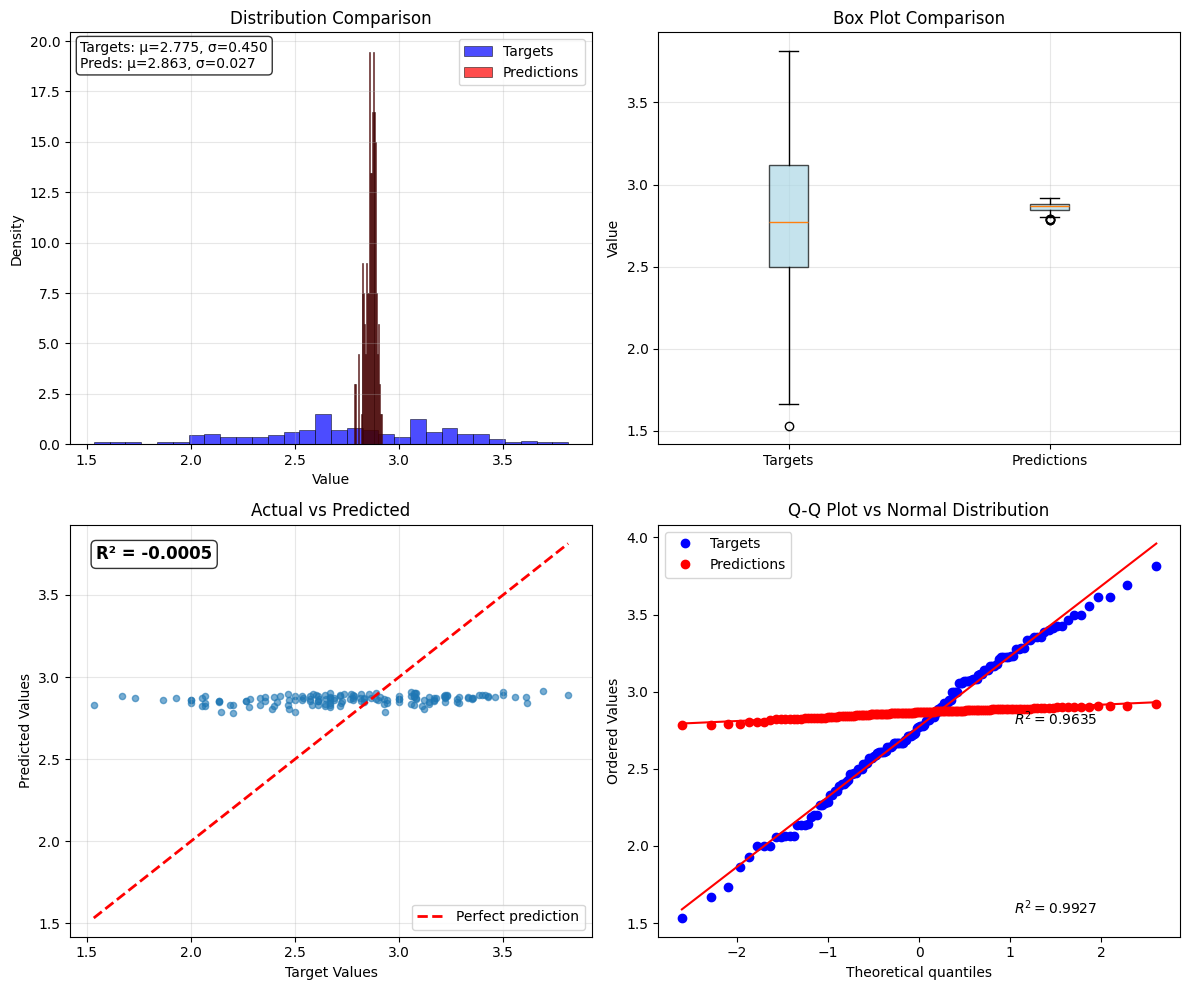


MODEL PERFORMANCE:
R² Score: -0.0005
MSE: 0.2030
MAE: 0.3673
--------------------------------------------------

DISTRIBUTION ANALYSIS
Targets    - Range: [1.533, 3.812]
Predictions- Range: [2.784, 2.918]
Target range span: 2.279
Prediction range span: 0.134
Range compression ratio: 0.059

Targets    - Mean: 2.775, Std: 0.450
Predictions- Mean: 2.863, Std: 0.027

Percentiles (5th, 25th, 50th, 75th, 95th):
Targets:     [2.02500001 2.5        2.77350426 3.11601317 3.44670336]
Predictions: [2.81839406 2.84760368 2.86767721 2.88196886 2.89988245]


In [ ]:
model_comparison(val_targets, val_preds, r2=val_r2, mse=val_mse, mae=val_mae)

/tmp/ipython-input-2415096797.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(box_data, labels=box_labels, patch_artist=True,


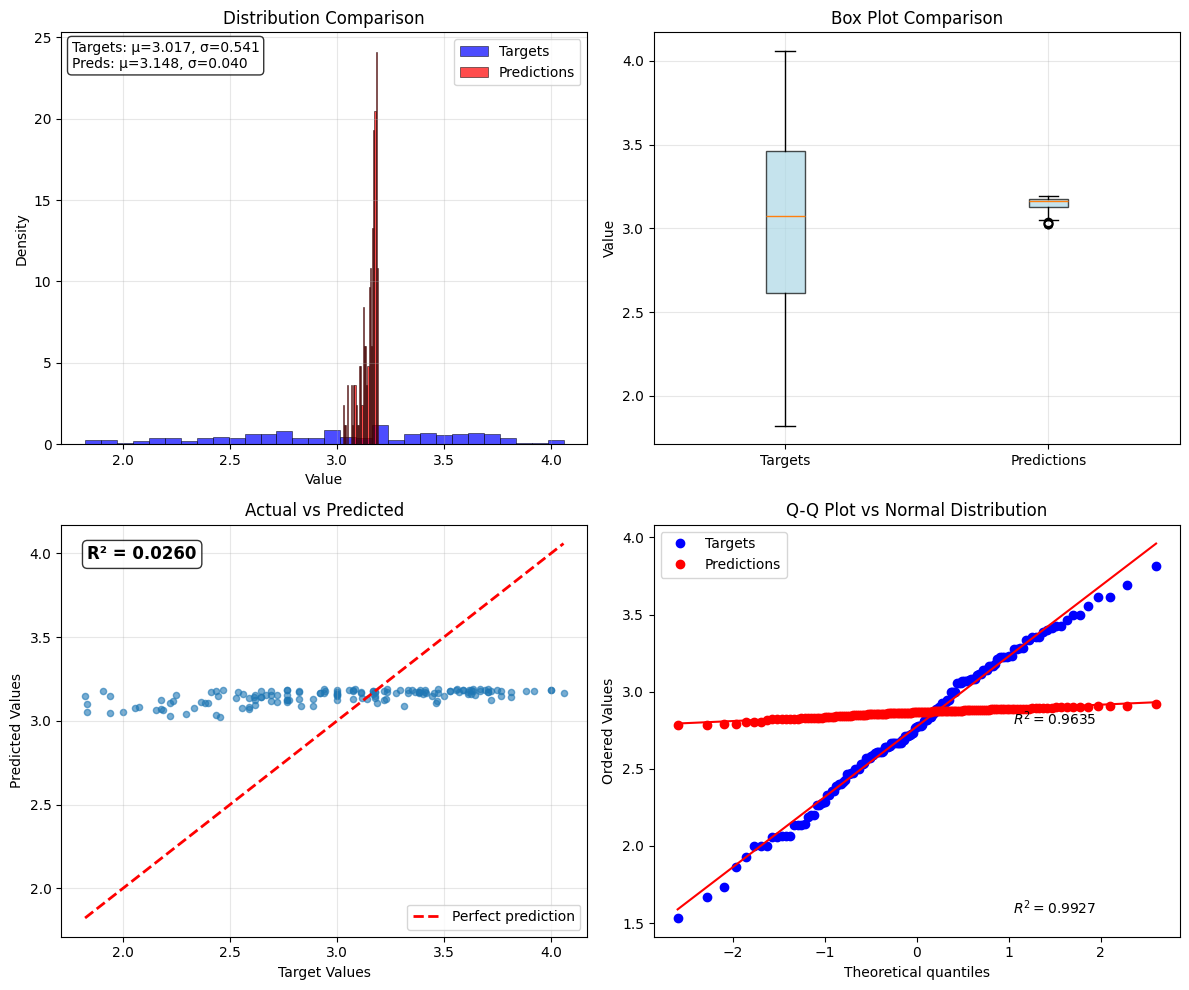


MODEL PERFORMANCE:
R² Score: 0.0260
MSE: 0.2847
MAE: 0.4401
--------------------------------------------------

DISTRIBUTION ANALYSIS
Targets    - Range: [1.824, 4.059]
Predictions- Range: [3.026, 3.192]
Target range span: 2.235
Prediction range span: 0.166
Range compression ratio: 0.074

Targets    - Mean: 3.017, Std: 0.541
Predictions- Mean: 3.148, Std: 0.040

Percentiles (5th, 25th, 50th, 75th, 95th):
Targets:     [2.06696838 2.61538458 3.07692313 3.45979029 3.7647059 ]
Predictions: [3.06713934 3.12556309 3.16318738 3.17854422 3.18773403]


In [ ]:
model_comparison(aro_targets, aro_preds, r2=aro_r2, mse=aro_mse, mae=aro_mae)

## Conclusions from 1st round of models:
This german fine-tuned version of the model isn't performing as good as the multi-language version (analysis done in a separate script), thus I will continue to optimize the multi-models only.